In [1]:
import pandas as pd
import json
import math
from math import cos
import matplotlib.pyplot as plt
import urllib,os
import seaborn as sns
from shapely.geometry import mapping,shape
from shapely.prepared import prep
from shapely.geometry import Point

### Functions used to get tge district of a given point in the same format they appear in the accidents dataset and the format they appear i the geojson object this is done to increase the efficiency since when iterating over a number of points a given point is more likely located in the same district as the one before and returning both values allows us to pass the district of the last point as argument and verify if the new point is located in the given district and only after looking up the other districts

In [2]:
with open("datasets/distritos_portugal.geojson") as f:
    district_data = json.load(f)

dataset_districts = {"Ã‰vora": "ÉVORA","Faro": "FARO","Beja": "BEJA","Guarda": "GUARDA","Coimbra" : "COIMBRA",
                    "Aveiro": "AVEIRO", "SetÃºbal": "SETÚBAL", "BraganÃ§a" : "BRAGANÇA", "Braga": "BRAGA",
                    "Lisboa": "LISBOA", "Porto" : "PORTO","Castelo Branco":"CASTELO BRANCO",
                    "SantarÃ©m": "SANTARÉM","Leiria":"LEIRIA","Portalegre":"PORTALEGRE","Madeira": "MADEIRA",
                     "Porto Santo": "PORTO SANTO","Viseu" : "VISEU", "Viana do Castelo":"VIANA DO CASTELO",
                    "Vila Real":"VILA REAL"}

  
districts = dict()
for feature in district_data["features"]:
    geom = feature["geometry"]
    district = feature["properties"]["distrito"]
    districts[district] = prep(shape(geom))

def  get_district(lon,lat,last_district="Faro"):
    point = Point(lon,lat)
    dist_geom = districts.get(last_district,None)
    
    if(dist_geom != None and dist_geom.contains(point)):
        return (dataset_districts[last_district],last_district)
        
    for district,geom in districts.items():
        if geom.contains(point):
            return (dataset_districts[district],district)
    return ("offbounds","offbounds")

In [3]:
get_district(-9.4593,38.7223)

('LISBOA', 'Lisboa')

### Given a geojson object the get_square functon returns the maximum values of latitude and longitude
### The isisn_square functions returns if a point is located in a given longitude and latitude ranges 

In [5]:
def get_square(geofile):
    
    with open(geofile) as f:
        geodict = json.load(f)
    lon_min,lon_max,lat_min,lat_max = math.inf,-math.inf,math.inf,-math.inf
    
    for i in geodict['features'][0]['geometry']['coordinates'][0]:
        print(i)
        if i[0] < lon_min: lon_min=i[0]
        if i[0] > lon_max: lon_max=i[0]
        if i[1] < lat_min: lat_min=i[1]
        if i[1] > lat_max: lat_max=i[1]
    
    
    return (lon_min,lon_max,lat_min,lat_max)

def isin_square(lon,lat,square_coordinates):
    lon_min,lon_max,lat_min,lat_max = square_coordinates;
    
    return (lon > lon_min) & (lon < lon_max) & (lat > lat_min) & (lat < lat_max)

coordinates = get_square('portugal.geojson')

isin_square(-7.2,37,coordinates)
    

[-10.12939453125, 36.80928470205937]
[-6.15234375, 36.80928470205937]
[-6.15234375, 42.61779143282346]
[-10.12939453125, 42.61779143282346]
[-10.12939453125, 36.80928470205937]


True

### Load the accidents dataset

In [7]:
accidents = pd.read_csv('datasets/road-accidents.csv')

C:\Users\hugoa\anaconda3\envs\keras\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
accidents.head()

,Numero,DataOcorrencia,DataFechoOperacional,Natureza,EstadoOcorrencia,Distrito,Concelho,Freguesia,Localidade,Latitude,Longitude,NumeroMeiosTerrestresEnvolvidos,NumeroOperacionaisTerrestresEnvolvidos,NumeroMeiosAereosEnvolvidos,NumeroOperacionaisAereosEnvolvidos
0,2016010098470,2016-01-10 00:30:00,NaN,Limpeza e Sinalização da via,Em Curso,AVEIRO,ALBERGARIA-A-VELHA,Albergaria-a-Velha e Valmaior,Rua 25 de Abril - Assilhó - Albergaria-a-Velha,40.692785,-8.479687,0.0,0.0,0.0,0.0
1,2016110047730,2016-03-14 09:00:00,2016-03-14 10:20:00,Colisão rodoviária,Encerrada,LISBOA,ALENQUER,Alenquer (Santo Estêvão e Triana),Alenquer,39.054242,-9.007918,1.0,2.0,0.0,0.0
2,2016130038635,2016-03-14 08:28:00,2016-03-14 09:15:00,Atropelamento,Encerrada,PORTO,VILA DO CONDE,Vila do Conde,Vila do Conde,41.352471,-8.735384,1.0,2.0,0.0,0.0
3,2016130038634,2016-03-14 08:25:00,2016-03-14 09:05:00,Limpeza e Sinalização da via,Encerrada,PORTO,SANTO TIRSO,Negrelos (São Tomé),NEGRELOS (SÃO TOMÉ),41.347422,-8.406756,1.0,2.0,0.0,0.0
4,2016040007263,2016-03-14 08:22:00,2016-03-14 09:55:00,Limpeza e Sinalização da via,Encerrada,BRAGANÇA,VILA FLOR,Vila Flor e Nabo,VILA FLOR E NABO,41.280009,-7.133590,1.0,2.0,0.0,0.0


### This function separates the dataset according to the camp "Distrito" doing this allows for looking up only the accidents occuring in the same district as the center of the area instead of looking up all accidents in the dataset

In [9]:
def get_dataframe_districts(dataframe):
    dataframes = dict()
    for i in dataframe['Distrito'].unique():
        dataframes[i] = dataframe.loc[dataframe["Distrito"] == i]
    return dataframes

dataframes_districts = get_dataframe_districts(accidents)
DISTRICTS = accidents['Distrito'].unique()

### Assuming the earth has a circunference of 40075 km this functions separate a square into a grid of n by n meters.It then rejects the squares whose center is outside of the country and sorts the squares by districts.After doing so it computes the number of accidents for each square in the grid.


In [10]:
def meters_to_lon(meters,latitude):
    ##lon_meters = latitude_meters*math.cos(math.radians(latitude))/(2*math.pi)
    ##print(lon_meters)
    latitude = math.radians(latitude)
    longitude_meters = 111412.84*cos(latitude) - 93.5 * cos(3*latitude) + 0.118*cos(5*latitude)
    return meters/longitude_meters

def meters_to_lat(meters,latitude):
    
    latitude = math.radians(latitude)
    latitude_meters = 111132.92 - 559.82 * cos(2*latitude) + 1.175*cos(4*latitude) - 0.0023*cos(6*latitude)
    return meters/latitude_meters

def generate_grid(coordinates,square_size,districts):
    
    lon_min,lon_max,lat_min,lat_max = coordinates
    grid = dict()

    for i in districts:
        grid[i] = list()
        
    current_lat = lat_min
    
    while(current_lat < lat_max):
        
        square_size_lat = meters_to_lat(square_size,current_lat)
        square_size_lon = meters_to_lon(square_size,lat_min)
        current_lon = lon_min
        last_district = "Faro"

        while(current_lon < lon_max):
            ##district="FARO"
            district,last_district = get_district(current_lon + square_size_lon/2,current_lat + square_size_lat/2,last_district)
            if(district != "offbounds"):
                grid[district].append([current_lon,current_lon + square_size_lon,current_lat,current_lat + square_size_lat,district.upper()])
                
            current_lon += square_size_lon

        current_lat += square_size_lat
        
    return grid


def create_grid_district_pd(points,dataset):
    new_grid = list()
    
    for i in points:
        
        min_lon,max_lon,min_lat,max_lat,district = i
        
        accidents_square = len(dataset[isin_square(dataset['Longitude'],
                                                        dataset['Latitude'],
                                                       (min_lon,max_lon,min_lat,max_lat))])
        
        new_grid.append([min_lon,max_lon,min_lat,max_lat,district,accidents_square])
        
    return new_grid

def create_grid_pd(coordinates,square_size,districts,df):
    grid = generate_grid(coordinates,square_size,districts)
    number_accidents = list()
    
    for i in grid:
            print(i)
            number_accidents.extend(create_grid_district_pd(grid[i],df[i]))
    
    
    return number_accidents


##grid = create_grid_csv(coordinates,200,get_dataframe_districts(accidents))

##grid = generate_grid(coordinates,200,DISTRICTS)
'''
print(len(grid))
for i in grid:
    print(f"{i} {len(grid[i])}")
'''
##len(grid['FARO'])


'\nprint(len(grid))\nfor i in grid:\n    print(f"{i} {len(grid[i])}")\n'

### create grid points for the district of lisbon

In [6]:
lisboa_grid = create_grid_district_pd(grid['LISBOA'],dataframes_districts['LISBOA'])

NameError: name 'grid' is not defined

### create the dataframe containing the grid cells from all districts

In [37]:
grid = create_grid_pd(coordinates,200,DISTRICTS,dataframes_districts)
grid_df = pd.DataFrame(grid,columns = ['MIN_LON','MAX_LON','MIN_LAT','MAX_LAT','DISTRICT','ACCIDENTS'])
grid_df.to_csv("datasets/grid_accidents.csv")
grid_df[200:]

AVEIRO
LISBOA
PORTO
BRAGANÇA
LEIRIA
VIANA DO CASTELO
FARO
SANTARÉM
VILA REAL
ÉVORA
BEJA
GUARDA
CASTELO BRANCO
SETÚBAL
BRAGA
COIMBRA
VISEU
PORTALEGRE
nan


,MIN_LON,MAX_LON,MIN_LAT,MAX_LAT,DISTRICT,ACCIDENTS
200,-8.524615,-8.522374,40.297353,40.299154,AVEIRO,0
201,-8.522374,-8.520133,40.297353,40.299154,AVEIRO,0
202,-8.520133,-8.517891,40.297353,40.299154,AVEIRO,0
203,-8.517891,-8.515650,40.297353,40.299154,AVEIRO,0
204,-8.515650,-8.513409,40.297353,40.299154,AVEIRO,0
...,...,...,...,...,...,...
2317333,-7.542921,-7.540679,39.659711,39.661513,PORTALEGRE,0
2317334,-7.540679,-7.538438,39.659711,39.661513,PORTALEGRE,0
2317335,-7.536197,-7.533955,39.659711,39.661513,PORTALEGRE,0
2317336,-7.533955,-7.531714,39.659711,39.661513,PORTALEGRE,0


### load the dataframe with the cells from all districts

In [2]:
grid_df = pd.read_csv("datasets/grid_accidents.csv")
grid_df = grid_df.drop(columns=['Unnamed: 0'])
grid_df[200:]

,MIN_LON,MAX_LON,MIN_LAT,MAX_LAT,DISTRICT,ACCIDENTS
200,-8.524615,-8.522374,40.297353,40.299154,AVEIRO,0
201,-8.522374,-8.520133,40.297353,40.299154,AVEIRO,0
202,-8.520133,-8.517891,40.297353,40.299154,AVEIRO,0
203,-8.517891,-8.515650,40.297353,40.299154,AVEIRO,0
204,-8.515650,-8.513409,40.297353,40.299154,AVEIRO,0
...,...,...,...,...,...,...
2317333,-7.542921,-7.540679,39.659711,39.661513,PORTALEGRE,0
2317334,-7.540679,-7.538438,39.659711,39.661513,PORTALEGRE,0
2317335,-7.536197,-7.533955,39.659711,39.661513,PORTALEGRE,0
2317336,-7.533955,-7.531714,39.659711,39.661513,PORTALEGRE,0


### Separate the grid dataframe into cells containing and not containing ACCIDENTS  

In [5]:
DANGER = grid_df[grid_df['ACCIDENTS'] > 0]
print(len(DANGER))

NO_DANGER = grid_df[grid_df['ACCIDENTS'] == 0]
print(len(NO_DANGER))

37919
2279419


C:\Users\hugoa\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\hugoa\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


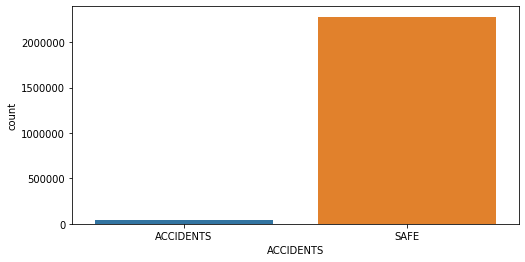

In [4]:
DANGER = grid_df[grid_df['ACCIDENTS'] > 0]
DANGER['ACCIDENTS'] = ["ACCIDENTS"]*len(DANGER)

SAFE = grid_df[grid_df['ACCIDENTS'] == 0]
SAFE['ACCIDENTS'] = ["SAFE"]*len(SAFE)

MODEL1 = pd.concat([DANGER,SAFE],axis=0)


plt.figure(figsize=(8,4))
chart = sns.countplot(x="ACCIDENTS",data =  MODEL1)
plt.show()

### Some graphics

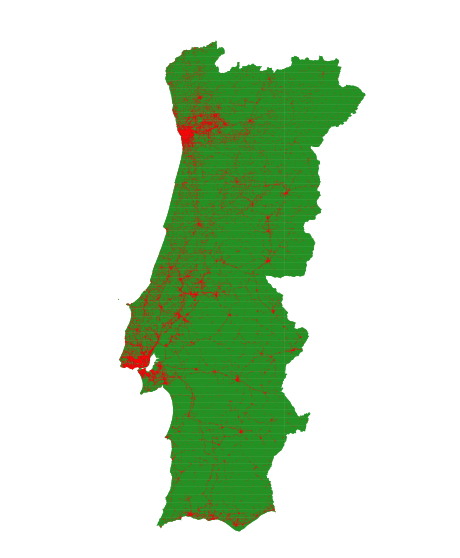

In [6]:
plt.figure(figsize=(8,10))
plt.scatter((NO_DANGER.MIN_LON+NO_DANGER.MAX_LON)/2,(NO_DANGER.MIN_LAT + NO_DANGER.MAX_LAT)/2,s=0.005,alpha=0.3,color='green')
plt.scatter((DANGER.MIN_LON+DANGER.MAX_LON)/2,(DANGER.MIN_LAT + DANGER.MAX_LAT)/2,s=0.005,alpha=0.8,color='red')

plt.xlim(-11,-5)
plt.ylim(36.75,42.5)
plt.axis('off')
plt.show()

## Create the data frame for the first model

In [34]:
DANGER = grid_df[grid_df['ACCIDENTS'] > 0]
DANGER['ACCIDENTS'] = [1]*len(DANGER)
DANGER.head()

C:\Users\hugoa\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MIN_LON,MAX_LON,MIN_LAT,MAX_LAT,DISTRICT,ACCIDENTS
55,-8.457376,-8.455135,40.288347,40.290148,AVEIRO,1
150,-8.479789,-8.477548,40.293750,40.295552,AVEIRO,1
213,-8.495478,-8.493237,40.297353,40.299154,AVEIRO,1
288,-8.486513,-8.484272,40.300955,40.302756,AVEIRO,1
392,-8.495478,-8.493237,40.306358,40.308160,AVEIRO,1


In [43]:
SAFE = grid_df[grid_df['ACCIDENTS'] == 0]
SAFE['ACCIDENTS'] = [0]*len(SAFE)
SAFE = SAFE.sample(n=len(DANGER) + int(len(DANGER) * 0.2),random_state=4)
    
SAFE.head()

C:\Users\hugoa\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MIN_LON,MAX_LON,MIN_LAT,MAX_LAT,DISTRICT,ACCIDENTS
1180905,-7.641538,-7.639297,37.546348,37.548150,BEJA,0
771869,-8.459617,-8.457376,39.420127,39.421929,SANTARÉM,0
2130059,-7.684123,-7.681882,41.005160,41.006961,VISEU,0
8417,-8.598579,-8.596337,40.479266,40.481067,AVEIRO,0
1423087,-7.191035,-7.188793,40.400017,40.401818,GUARDA,0


In [44]:
MODEL1 = pd.concat([DANGER,SAFE],axis=0)

MODEL1.head()

,MIN_LON,MAX_LON,MIN_LAT,MAX_LAT,DISTRICT,ACCIDENTS
55,-8.457376,-8.455135,40.288347,40.290148,AVEIRO,1
150,-8.479789,-8.477548,40.293750,40.295552,AVEIRO,1
213,-8.495478,-8.493237,40.297353,40.299154,AVEIRO,1
288,-8.486513,-8.484272,40.300955,40.302756,AVEIRO,1
392,-8.495478,-8.493237,40.306358,40.308160,AVEIRO,1


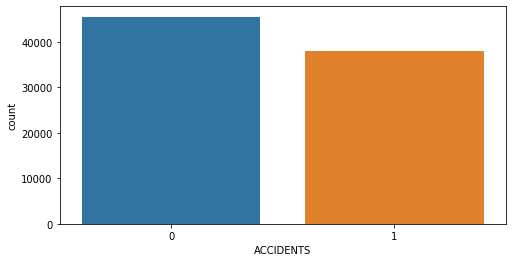

In [45]:
plt.figure(figsize=(8,4))
chart = sns.countplot(x="ACCIDENTS",data =  MODEL1)
plt.show()

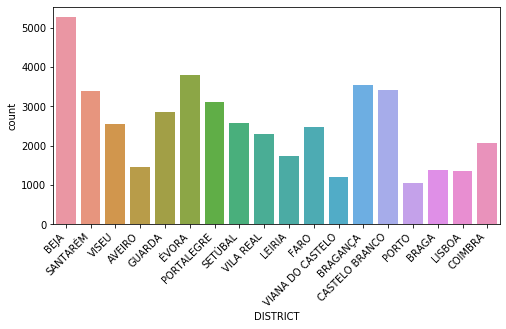

In [46]:
plt.figure(figsize=(8,4))
chart = sns.countplot(x="DISTRICT",data = SAFE[SAFE['ACCIDENTS'] == 0])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

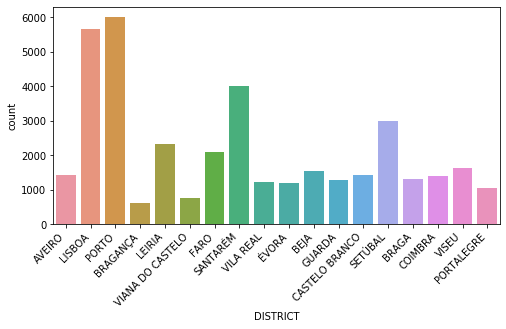

In [47]:
plt.figure(figsize=(8,4))
chart = sns.countplot(x="DISTRICT",data = DANGER[DANGER['ACCIDENTS'] == 1])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [76]:
MODEL1.to_csv("datasets/MODEL1.csv")

## CREATE THE DATAFRAME FOR THE SECOND MODEL - first version in this version we create a dataset dividing the cells containing accidents in different risk levels

In [16]:
def find_balanced_categories(dataset,nr_divisions):
    maximum = max(dataset['ACCIDENTS'])
    ##print(len(dataset[dataset['ACCIDENTS'] == 1]))
    rows = len(dataset)
    divisions = list()
    print(maximum)
    start = 0
    fraction_dataset = 0
    for i in range(maximum+1):
        repetitions = len(dataset[dataset['ACCIDENTS'] == i])
        ##print(repetitions)
        if(fraction_dataset > 1/nr_divisions):
            if(abs(1/nr_divisions - fraction_dataset) < abs(1/nr_divisions - fraction_dataset - repetitions)):
                divisions.append((start,i))
                start = i
                print(fraction_dataset)

                fraction_dataset = repetitions/rows

            else:
                divisions.append((start,i+1))
                start = i+1
                print(fraction_dataset)

                fraction_dataset = 0
        
        else:
            fraction_dataset += repetitions/rows
            ##print(fraction_dataset)
        ##print(repetitions/rows)
    
    print(fraction_dataset)
    divisions.append((start,maximum+1))
    
    return divisions

In [38]:
DANGER = grid_df[grid_df['ACCIDENTS'] > 0]
divisions = find_balanced_categories(DANGER,5)
divisions

485
0.6830612621640866
0.2183074448165827
0.09863129301933034


[(0, 2), (2, 5), (5, 486)]

In [53]:
datasets = list()
danger_score = 0
divisions = [(1,2),(2,3),(3,4),(4,5),(5,486)]
for start,end in divisions:
    df_dangeri = DANGER[(DANGER['ACCIDENTS'] >= start) & (DANGER['ACCIDENTS'] < end)]
    if danger_score == len(divisions) -1:
        df_dangeri['ACCIDENTS']  = [f"[{divisions[danger_score][0]}-{divisions[danger_score][1]}["] * len(df_dangeri)
    else:
        df_dangeri['ACCIDENTS']  = [str(danger_score + 1)] * len(df_dangeri)

    datasets.append(df_dangeri)
    danger_score += 1

MODEL2 = pd.concat(datasets,axis=0)
print(len(MODEL2))
MODEL2.head()

37919


C:\Users\hugoa\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\hugoa\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,MIN_LON,MAX_LON,MIN_LAT,MAX_LAT,DISTRICT,ACCIDENTS
150,-8.479789,-8.477548,40.293750,40.295552,AVEIRO,1
213,-8.495478,-8.493237,40.297353,40.299154,AVEIRO,1
392,-8.495478,-8.493237,40.306358,40.308160,AVEIRO,1
551,-8.477548,-8.475306,40.317165,40.318966,AVEIRO,1
661,-8.448411,-8.446169,40.324370,40.326171,AVEIRO,1


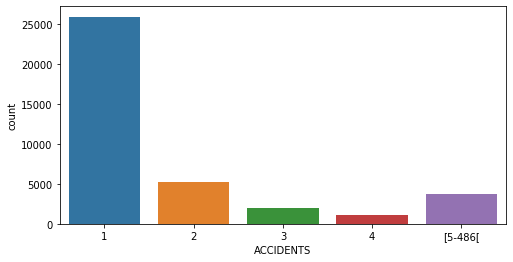

In [54]:
plt.figure(figsize=(8,4))
chart = sns.countplot(x="ACCIDENTS",data = MODEL2)
plt.show()

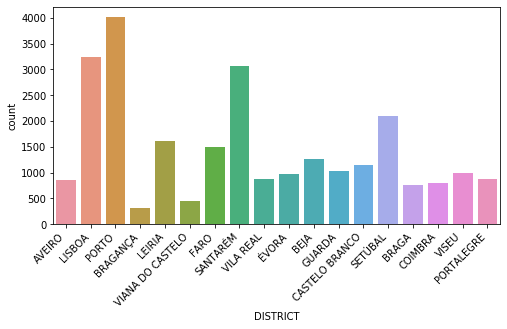

In [55]:
plt.figure(figsize=(8,4))
chart = sns.countplot(x="DISTRICT",data = MODEL2[MODEL2['ACCIDENTS'] == "1"])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

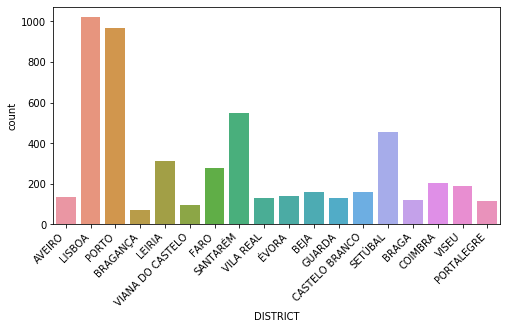

In [56]:
plt.figure(figsize=(8,4))
chart = sns.countplot(x="DISTRICT",data = MODEL2[MODEL2['ACCIDENTS'] == "2"])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

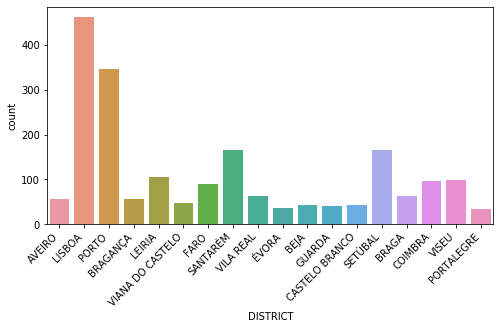

In [58]:
plt.figure(figsize=(8,4))
chart = sns.countplot(x="DISTRICT",data = MODEL2[MODEL2['ACCIDENTS'] == "3"])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

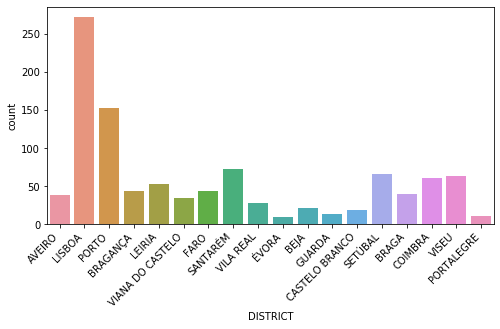

In [59]:
plt.figure(figsize=(8,4))
chart = sns.countplot(x="DISTRICT",data = MODEL2[MODEL2['ACCIDENTS'] == "4"])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

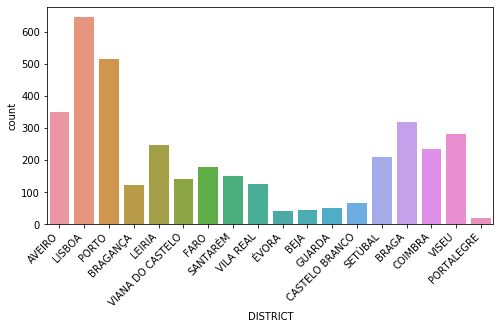

In [60]:
plt.figure(figsize=(8,4))
chart = sns.countplot(x="DISTRICT",data = MODEL2[MODEL2['ACCIDENTS'] == "[5-486["])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

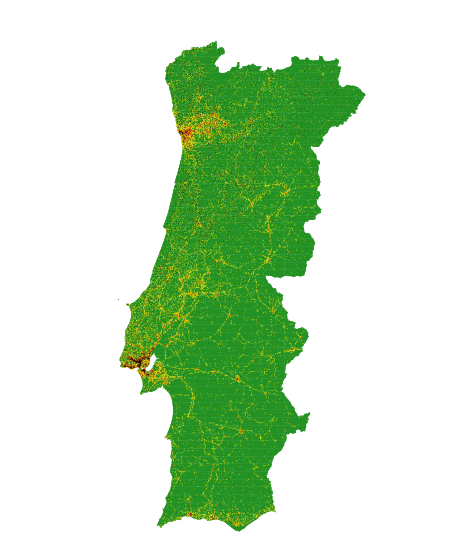

In [63]:
LEVEL1 = MODEL2[MODEL2['ACCIDENTS'] == "1"]
LEVEL2 = MODEL2[MODEL2['ACCIDENTS'] == "2"]
LEVEL3 = MODEL2[MODEL2['ACCIDENTS'] == "3"]
LEVEL4 = MODEL2[MODEL2['ACCIDENTS'] == "4"]
LEVEL5 = MODEL2[MODEL2['ACCIDENTS'] == "[5-486["]

plt.figure(figsize=(8,10))
plt.scatter((NO_DANGER.MIN_LON+NO_DANGER.MAX_LON)/2,(NO_DANGER.MIN_LAT + NO_DANGER.MAX_LAT)/2,s=0.005,alpha=0.3,color='green')
plt.scatter((LEVEL1.MIN_LON+LEVEL1.MAX_LON)/2,(LEVEL1.MIN_LAT + LEVEL1.MAX_LAT)/2,s=0.01,alpha=0.8,color='yellow')
plt.scatter((LEVEL2.MIN_LON+LEVEL2.MAX_LON)/2,(LEVEL2.MIN_LAT + LEVEL2.MAX_LAT)/2,s=0.01,alpha=0.8,color="orange")
plt.scatter((LEVEL3.MIN_LON+LEVEL3.MAX_LON)/2,(LEVEL3.MIN_LAT + LEVEL3.MAX_LAT)/2,s=0.01,alpha=0.8,color='red')
plt.scatter((LEVEL4.MIN_LON+LEVEL4.MAX_LON)/2,(LEVEL4.MIN_LAT + LEVEL4.MAX_LAT)/2,s=0.01,alpha=0.8,color="grey")
plt.scatter((LEVEL5.MIN_LON+LEVEL5.MAX_LON)/2,(LEVEL5.MIN_LAT + LEVEL5.MAX_LAT)/2,s=0.01,alpha=0.8,color='black')

plt.xlim(-11,-5)
plt.ylim(36.75,42.5)
plt.axis('off')
plt.show()

In [75]:
MODEL2.to_csv("datasets/MODEL2.csv")

## CREATE THE DATAFRAME FOR THE SECOND MODEL - second version in this version we create a dataset containing a score associated with the risk level of each of the cells the score is computed using the distribution of the accidents 

In [7]:
def compute_distribution(df):
    distribution = dict()
    
    maximum = max(df['ACCIDENTS'])
    
    counts = dict(df['ACCIDENTS'].value_counts(dropna=False))
    dist = dict()
    
    total = float(sum([counts[x] for x in counts]))
    keys = sorted(counts.keys())
    
    current_sum = 0
    
    for key in keys:
        dist[key] = 100 * float(current_sum) / total
        current_sum += counts[key]
    
    return dist

In [8]:
DANGER = grid_df[grid_df['ACCIDENTS'] > 0]

In [9]:
danger_distribution = compute_distribution(DANGER)

In [10]:
def create_accident_distribution_dataset(df):
    danger_distribution = compute_distribution(df)
    
    distribution_dataset = df
    distribution_dataset['ACCIDENTS'].replace(danger_distribution,inplace=True)
    
    return distribution_dataset

In [11]:
MODEL2_V2 = create_accident_distribution_dataset(DANGER)

C:\Users\hugoa\anaconda3\envs\keras\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [12]:
print(len(MODEL2_V2))
MODEL2_V2.head()

37919


,MIN_LON,MAX_LON,MIN_LAT,MAX_LAT,DISTRICT,ACCIDENTS
55,-8.457376,-8.455135,40.288347,40.290148,AVEIRO,82.077586
150,-8.479789,-8.477548,40.293750,40.295552,AVEIRO,0.000000
213,-8.495478,-8.493237,40.297353,40.299154,AVEIRO,0.000000
288,-8.486513,-8.484272,40.300955,40.302756,AVEIRO,96.228804
392,-8.495478,-8.493237,40.306358,40.308160,AVEIRO,0.000000


In [13]:
MODEL2_V2['ACCIDENTS'].value_counts(dropna=False)

0.000000     25901
68.306126     5222
82.077586     2011
87.380996     1045
90.136871      635
             ...  
99.920884        1
99.704634        1
99.852317        1
99.918247        1
99.960442        1
Name: ACCIDENTS, Length: 169, dtype: int64

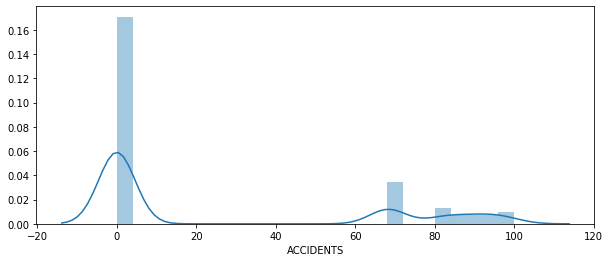

In [14]:
f,ax = plt.subplots(figsize=(10,4))
chart = sns.distplot(MODEL2_V2['ACCIDENTS'],hist = True, kde = True,ax=ax)
plt.show()

In [73]:
MODEL2_V2.to_csv("datasets/MODEL2_v2.csv")

### Function used to get images form the MapBox static API
### The MapBox static API allows the use of its images for non profit projects their quality is comparable to the Bing Maps API and the Google Maps static API

In [77]:
def GetImageMapBox(coord,SaveLoc):
    latitude,longitude = coord.split(",")
    sizex = 365
    sizey = 365
    zoom = 19
    file = coord + ".jpg"
    token = "pk.eyJ1IjoiaHVnb21hbiIsImEiOiJjazczcWN5enEwZWR6M2Vtc2NwdG41YnB2In0.XzksnuqKWS2TFcTvzbDIIw"
    link =  f"https://api.mapbox.com/styles/v1/mapbox/satellite-v9/static/{longitude},{latitude},{zoom}/{sizex}x{sizey}?access_token={token}"
    ##print(link)
    urllib.request.urlretrieve(link, os.path.join(SaveLoc,file))

### Function used to get static images from the Bing Maps API

In [78]:
def getImageBing(latitude,longitude,SaveLoc):
    key = "Aqk4d8d5q_eWvI3oGYPNI-NdIuS5fEt3U-AnDWxNAzyM2Dn_v2vn2BbgD_8F-jIh"
    link = f"https://dev.virtualearth.net/REST/v1/Imagery/Map/Aerial/{latitude},{longitude}/19?mapSize=500,500&key={key}"
    file = str(latitude) + "," + str(longitude) + ".png"
    urllib.request.urlretrieve(link, os.path.join(SaveLoc,file))
    

In [79]:
getImageBing(41.5454,-8.4265,"")

### download the images in a given dataset the images are downloaded using each cells center point to get an aerial view image using the Bing Maps static maps API

In [80]:
def download_images(df):
    for i in df.index:
        min_lon,max_lon,min_lat,max_lat = df['MIN_LON'][i],df['MAX_LON'][i],df['MIN_LAT'][i],df['MAX_LAT'][i]
        avg_lon = (min_lon + max_lon)/2
        avg_lat = (min_lat + max_lat)/2
        if(df['ACCIDENTS'][i] > 0):
            saveloc = "ACCIDENTS"
        else:
            saveloc = "SAFE"
            
        getImageBing(avg_lat,avg_lon,saveloc)

In [81]:
ACCIDENTS = grid_df.loc[grid_df['ACCIDENTS'] > 0].sample(n=40,random_state=1)
ACCIDENTS

,MIN_LON,MAX_LON,MIN_LAT,MAX_LAT,DISTRICT,ACCIDENTS
972318,-7.838774,-7.836533,38.348183,38.349985,ÉVORA,1
188143,-8.403584,-8.401343,41.275293,41.277094,PORTO,1
847962,-7.516025,-7.513784,41.273492,41.275293,VILA REAL,1
875110,-7.845498,-7.843256,41.460777,41.462577,VILA REAL,3
75156,-9.436829,-9.434588,38.704919,38.706721,LISBOA,3
1833675,-9.208215,-9.205974,38.645465,38.647266,SETÚBAL,1
1878765,-8.461859,-8.459617,41.509398,41.511198,BRAGA,1
122967,-9.262007,-9.259766,39.086855,39.088656,LISBOA,1
2251967,-7.421890,-7.419649,39.212960,39.214762,PORTALEGRE,1
1035036,-8.105490,-8.103249,38.580604,38.582406,ÉVORA,1


In [85]:
download_images(ACCIDENTS)

In [84]:
SAFE = grid_df.loc[grid_df['ACCIDENTS'] == 0].sample(n=40,random_state=1)
SAFE

,MIN_LON,MAX_LON,MIN_LAT,MAX_LAT,DISTRICT,ACCIDENTS
2050575,-8.161523,-8.159281,40.560314,40.562115,VISEU,0
2208274,-7.789465,-7.787224,39.063435,39.065236,PORTALEGRE,0
1703561,-7.504818,-7.502577,40.239716,40.241517,CASTELO BRANCO,0
1924849,-8.352034,-8.349793,39.973137,39.974938,COIMBRA,0
573987,-7.914978,-7.912737,37.173323,37.175125,FARO,0
1454786,-7.594471,-7.592230,40.531497,40.533298,GUARDA,0
1083150,-7.394994,-7.392753,38.726539,38.728340,ÉVORA,0
1112710,-7.605677,-7.603436,38.823826,38.825628,ÉVORA,0
1992877,-8.062905,-8.060664,40.261330,40.263131,COIMBRA,0
2081952,-8.069629,-8.067388,40.735015,40.736816,VISEU,0


In [86]:
download_images(SAFE)

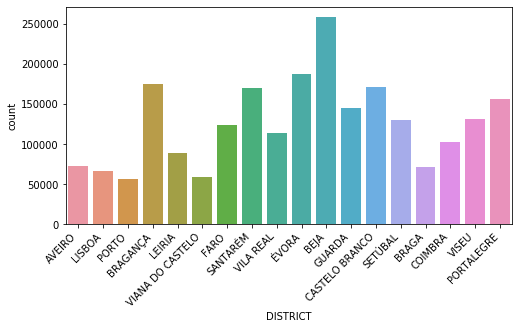

In [87]:
plt.figure(figsize=(8,4))
chart = sns.countplot(x="DISTRICT",data = grid_df[grid_df['ACCIDENTS'] == 0])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

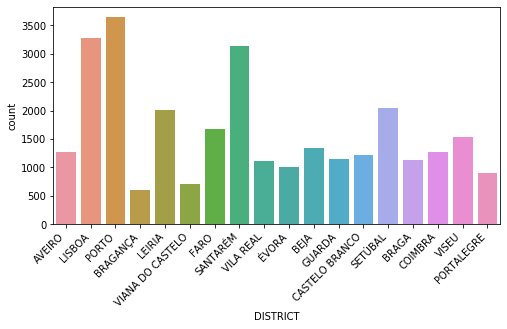

In [28]:
plt.figure(figsize=(8,4))
chart = sns.countplot(x="DISTRICT",data = grid_df[grid_df['ACCIDENTS'] > 0])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

c:\users\hugoa\anaconda3\envs\tf_gpu\lib\site-packages\seaborn\distributions.py:200: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  line, = ax.plot(a.mean(), 0)
c:\users\hugoa\anaconda3\envs\tf_gpu\lib\site-packages\seaborn\distributions.py:352: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)
c:\users\hugoa\anaconda3\envs\tf_gpu\lib\site-packages\matplotlib\ticker.py:1123: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


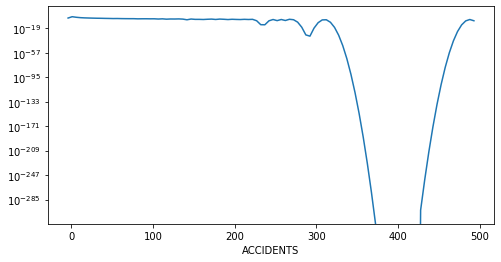

In [44]:
f,ax = plt.subplots(figsize=(8,4))
ax.set(yscale = "log")
chart = sns.distplot(grid_df[grid_df['ACCIDENTS'] > 0]['ACCIDENTS'],hist = False, kde = True,ax=ax)
plt.show()

In [34]:
max(grid_df['ACCIDENTS'].values)

488